In [2]:
import pandas as pd
import herepy
from tqdm.notebook import tqdm
from collections import defaultdict
import re
import requests
import urllib
import xmltodict
import json
import numpy as np
#packages for R in python
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
#CPD
from pgmpy.models import BayesianModel
import pgmpy
# from pgmpy.estimators import ConstraintBasedEstimator
#bnlearn
import bnlearn
import torch
import pyro
import pyro.distributions as dist
from statistics import mean
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Image

%matplotlib inline

In [ ]:
listings_full = pd.read_csv('data/listings_full.csv')

In [ ]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def herePy(coordinate1,coordinate2):
    coordinates = coordinate1+','+coordinate2
    locator = Nominatim(user_agent="myGeocoder")
    address = locator.reverse(coordinates)
    address = address.raw
    return pd.Series([address.get('display_name',None),
                      address['address'].get('house_number',address['address'].get('building',None)),
                      address['address'].get('road',None),
                      address['address'].get('country',None),
                      address['address'].get('postcode',None)],
                     index=['Address','House','Street','Country',
                            'PostalCode'])

In [ ]:
tqdm.pandas()

listings_full[['Address','HouseNumber','Street','Country','PostalCode']] = listings_full.progress_apply(lambda row: herePy(str(row['latitude']), str(row['longitude'])) , axis=1)

In [ ]:
listings_full['Street'].unique()

In [ ]:
listings_subset = listings_full[['id','Zestimate','bedrooms','bathrooms','beds','accommodates','amenities_score',
               'bikeScore','walkScore','transitScore','neighbourhood_cleansed','property_type',
               'publicSchoolScores','closenessToDowntown','price','minimum_nights_avg_ntm','roi','Street']]

pd.options.mode.chained_assignment = None
listings_subset['property_type'] = listings_subset['property_type'].astype('category')
listings_subset['bathrooms'] = listings_subset['bathrooms'].astype('category')
listings_subset['neighbourhood'] = listings_subset['neighbourhood_cleansed'].astype('category')
listings_subset['street'] = listings_subset['Street'].astype('category')
del listings_subset['neighbourhood_cleansed']
del listings_subset['Street']

listings_subset['roi'] = listings_subset['roi'].astype('float')
listings_subset['Zestimate'] = listings_subset['Zestimate'].astype('float')
listings_subset['bedrooms'] = listings_subset['bedrooms'].astype('float')
listings_subset['beds'] = listings_subset['beds'].astype('float')
listings_subset['accommodates'] = listings_subset['accommodates'].astype('float')
listings_subset['amenities_score'] = listings_subset['amenities_score'].astype('float')
listings_subset['publicSchoolScores'] = listings_subset['publicSchoolScores'].astype('float')
listings_subset['closenessToDowntown'] = listings_subset['closenessToDowntown'].astype('float')
listings_subset['price'] = listings_subset['price'].astype('float')
listings_subset['minimum_nights_avg_ntm'] = listings_subset['minimum_nights_avg_ntm'].astype('float')
pd.options.mode.chained_assignment = 'warn'

In [ ]:
listing_cat = listings_subset[['bathrooms','bikeScore','walkScore','transitScore','property_type','neighbourhood','street']]
listings_n_cat = listings_subset[['roi','Zestimate','bedrooms','beds','accommodates','amenities_score','publicSchoolScores','closenessToDowntown','price','minimum_nights_avg_ntm']]

In [ ]:
def rDiscretize(data):
    utils = importr('utils')
    utils.install_packages('bnlearn')
    # utils.install_packages('base')
    bnlearnR = importr('bnlearn')
    bnDiscretize = bnlearnR.discretize
    # Import Functions
    pandas2ri.activate()
    r_dt = ro.conversion.py2rpy(data) #convert pandas to RDataframe
    r_dt2 = bnDiscretize(r_dt,method= "hartemink", breaks = 3, ibreaks=3)
    pd_dt = ro.conversion.rpy2py(r_dt2)
    pd_dt.reset_index(drop=True)
    return pd_dt

In [ ]:
listings_fac = rDiscretize(listings_n_cat)

In [ ]:
data_discrete = listings_fac.reset_index(drop=True).join(listing_cat)
data_discrete

In [ ]:
data_discrete.to_csv('data/final.csv')

In [3]:
data_discrete = pd.read_csv('data/final.csv')

In [6]:
data_discrete['mobility']= data_discrete[['bikeScore', 'walkScore', 'transitScore']].mean(axis=1)
data_discrete

,Unnamed: 0,roi,Zestimate,bedrooms,beds,accommodates,amenities_score,publicSchoolScores,closenessToDowntown,price,minimum_nights_avg_ntm,bathrooms,bikeScore,walkScore,transitScore,property_type,neighbourhood,street,mobility
0,0,"[-38.1201,-12.0209]","(870941,1.14825e+07]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","(4704.33,19715]","(135,199]","(28,353]",1.0,3,5,3,Apartment,Dorchester,Boston Street,3.666667
1,1,"(-12.0209,9.92724]","(544583,870941]","[0,1]","[0,1]","[2,3]","[12,30]","(3.70142,5.27273]","(4704.33,19715]","(135,199]","(2,28]",1.0,4,5,3,Apartment,Jamaica Plain,Goodrich Road,4.000000
2,2,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","(30,33]","(3.70142,5.27273]","(2400.33,4704.33]","(199,5555]","[1,2]",1.0,3,4,4,Apartment,Charlestown,Salem Street,3.666667
3,3,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","[12,30]","(3.47373,3.70142]","(2400.33,4704.33]","[60,135]","(2,28]",1.0,3,5,4,Apartment,Charlestown,Winthrop Street,4.000000
4,4,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","(30,33]","(3.70142,5.27273]","(4704.33,19715]","(135,199]","(2,28]",1.0,4,4,3,Apartment,Allston,Easton Street,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,"(9.92724,1270.48]","[165887,544583]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","[898,2400.33]","(199,5555]","(28,353]",2.0,3,5,5,Apartment,Downtown,Winter Street,4.333333
196,196,"(9.92724,1270.48]","[165887,544583]","(1,2]","(1,2]","(3,5]","(30,33]","[2.75,3.47373]","[898,2400.33]","(135,199]","(28,353]",1.0,3,5,5,Apartment,Downtown,Bromfield Street,4.333333
197,197,"(9.92724,1270.48]","[165887,544583]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","[898,2400.33]","(199,5555]","(28,353]",2.0,3,5,5,Apartment,Downtown,Bromfield Street,4.333333
198,198,"[-38.1201,-12.0209]","(870941,1.14825e+07]","(1,2]","(1,2]","(3,5]","(30,33]","[2.75,3.47373]","[898,2400.33]","(135,199]","(28,353]",1.0,3,5,5,Apartment,Downtown,Hamilton Place,4.333333


In [7]:
nodes = ['amenities_score','bathrooms','bedrooms','Zestimate','neighbourhood',
         'roi','price','minimum_nights_avg_ntm','publicSchoolScores', 'mobility',
         'property_type','closenessToDowntown','accommodates','beds','street']
edges = [('amenities_score','price'),
         ('bathrooms','price'),
         ('bathrooms','Zestimate'),
         ('bedrooms','price'),
         ('bedrooms','beds'),
         ('bedrooms','accommodates'),
         ('bedrooms','Zestimate'),
         ('property_type','price'),
         ('property_type','Zestimate'),
         ('price','roi'),
         ('mobility','Zestimate'),
         ('mobility','price'),
         ('Zestimate','roi'),
         ('beds','price'),
         ('accommodates','price'),
         ('neighbourhood','street'),
         ('street','price'),
         ('street','mobility'),
         ('street','publicSchoolScores'),
         ('publicSchoolScores','Zestimate'),
         ('street','Zestimate'),
         ('street','closenessToDowntown'),
         ('closenessToDowntown','price'),                    
         ('minimum_nights_avg_ntm','price')]

In [8]:
from pgmpy.models import BayesianModel
graph = BayesianModel()

graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

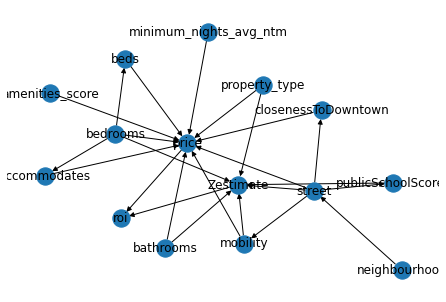

<Figure size 14400x7200 with 0 Axes>

In [10]:
import networkx as nx
import pydot

DAG_11 = nx.DiGraph()
DAG_11.add_edges_from(edges)
pos_11 = nx.nx_pydot.graphviz_layout(DAG_11, prog='dot')
nx.draw(DAG_11, pos=pos_11, with_labels=True)
plt.figure(figsize=(200,100))
plt.show()

In [11]:
def adjacencyMatrix(edges):
    df = pd.DataFrame(edges, columns =['source','target'], dtype = float) 
    df = pd.crosstab(df.source, df.target)
    idx = df.columns.union(df.index)
    df2 = df.reindex(index = idx, columns=idx, fill_value=0)
    df2.index.name = "source"
    df2 = df2.rename_axis('target')
    return df2

In [12]:
adjMat = adjacencyMatrix(edges)

In [ ]:
adjMat

In [13]:
data_discrete = data_discrete.astype(object)
model ={'adjmat':adjMat, 'model':graph}

model_update = bnlearn.parameter_learning.fit(model, data_discrete, verbose=1)